## 간호사 월급 예측

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb

import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font',family=font)

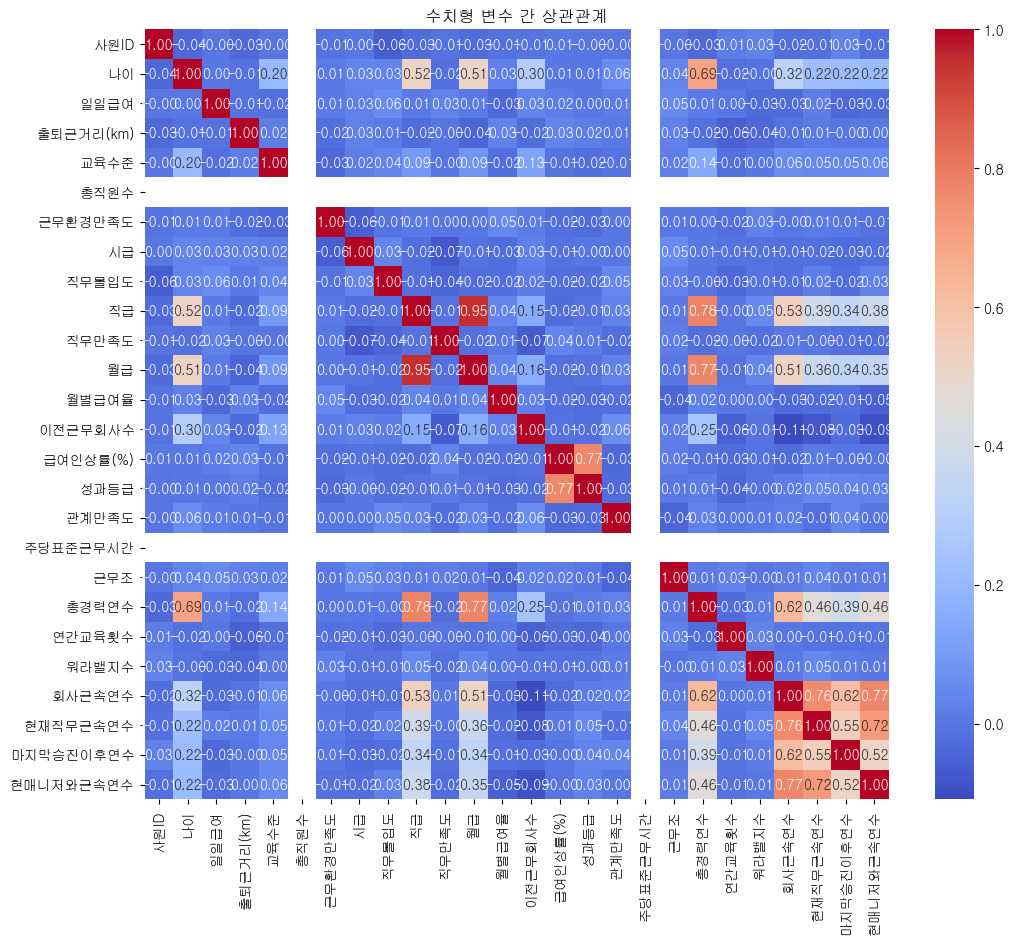

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   나이        1676 non-null   int64 
 1   퇴사여부      1676 non-null   object
 2   출장빈도      1676 non-null   object
 3   부서        1676 non-null   object
 4   전공분야      1676 non-null   object
 5   총직원수      1676 non-null   int64 
 6   성별        1676 non-null   object
 7   직급        1676 non-null   int64 
 8   직무        1676 non-null   object
 9   결혼상태      1676 non-null   object
 10  월급        1676 non-null   int64 
 11  성인여부      1676 non-null   object
 12  초과근무여부    1676 non-null   object
 13  주당표준근무시간  1676 non-null   int64 
 14  총경력연수     1676 non-null   int64 
 15  회사근속연수    1676 non-null   int64 
dtypes: int64(7), object(9)
memory usage: 209.6+ KB


In [99]:
# 1. 데이터 불러오기
df = pd.read_csv('data/watson_healthcare_modified.csv')

# 1-1. 컬럼명을 한국어로 변경
df = df.rename(columns={
    'EmployeeID': '사원ID',
    'Age': '나이',
    'Attrition': '퇴사여부',
    'BusinessTravel': '출장빈도',
    'DailyRate': '일일급여',
    'Department': '부서',
    'DistanceFromHome': '출퇴근거리(km)',
    'Education': '교육수준',
    'EducationField': '전공분야',
    'EmployeeCount': '총직원수',
    'EnvironmentSatisfaction': '근무환경만족도',
    'Gender': '성별',
    'HourlyRate': '시급',
    'JobInvolvement': '직무몰입도',
    'JobLevel': '직급',
    'JobRole': '직무',
    'JobSatisfaction': '직무만족도',
    'MaritalStatus': '결혼상태',
    'MonthlyIncome': '월급',
    'MonthlyRate': '월별급여율',
    'NumCompaniesWorked': '이전근무회사수',
    'Over18': '성인여부',
    'OverTime': '초과근무여부',
    'PercentSalaryHike': '급여인상률(%)',
    'PerformanceRating': '성과등급',
    'RelationshipSatisfaction': '관계만족도',
    'StandardHours': '주당표준근무시간',
    'Shift': '근무조',
    'TotalWorkingYears': '총경력연수',
    'TrainingTimesLastYear': '연간교육횟수',
    'WorkLifeBalance': '워라밸지수',
    'YearsAtCompany': '회사근속연수',
    'YearsInCurrentRole': '현재직무근속연수',
    'YearsSinceLastPromotion': '마지막승진이후연수',
    'YearsWithCurrManager': '현매니저와근속연수'
})

# display(df)

# # 2. 데이터 구조 및 기초 통계 확인
# print("데이터 구조 정보:")
# print(df.info())

# print("기초 통계 요약:")
# print(df.describe())

# # 3. 결측치 및 이상치 탐색
# print("결측치 확인:")
# print(df.isnull().sum())


# # 4. 데이터 시각화를 통한 탐색

# # 퇴사여부 분포
# plt.figure(figsize=(5, 4))
# sns.countplot(data=df, x='퇴사여부')
# plt.title("퇴사 여부 분포")
# plt.show()

# # 월급 분포
# plt.figure(figsize=(6, 4))
# sns.histplot(df['월급'], kde=True, bins=30)
# plt.title("월급 분포")
# plt.xlabel("Monthly Income")
# plt.show()

# 상관관계 히트맵
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("수치형 변수 간 상관관계")
plt.show()

income_corr = corr['월급']

# 절댓값이 0.1 미만인 컬럼 추출
low_corr_features = income_corr[abs(income_corr) < 0.5].index.tolist()

# 해당 컬럼 드랍
df = df.drop(columns=low_corr_features)
df.info()




# 7. 데이터 분할
from sklearn.model_selection import train_test_split

# X = df_encoded.drop(columns=['월급'])
# y = df_encoded['월급']  

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("학습용 데이터 크기:", X_train.shape)
# print("테스트용 데이터 크기:", X_test.shape)


In [ ]:

# 범주형 변수 원핫 인코딩
df_encoded = pd.get_dummies(df, drop_first=True)

# 피처, 타겟 분리
X = df_encoded.drop(columns=['월급'])
y = df_encoded['월급']

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링 (선형 회귀, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 평가 함수
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"[{name}]")
    print(f" - MSE: {mse:.2f}")
    print(f" - R^2: {r2:.4f}\n")

# 모델 학습 및 평가
# 선형 회귀
evaluate_model("선형 회귀", LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test)

# 랜덤 포레스트
evaluate_model("랜덤 포레스트", RandomForestRegressor(random_state=42), X_train, X_test, y_train, y_test)

# KNN
evaluate_model("KNN", KNeighborsRegressor(n_neighbors=5), X_train_scaled, X_test_scaled, y_train, y_test)

# XGBoost
evaluate_model("XGBoost", xgb.XGBRegressor(random_state=42, objective='reg:squarederror'), X_train, X_test, y_train, y_test)

[선형 회귀]
 - MSE: 1745417.45
 - R^2: 0.9264

[랜덤 포레스트]
 - MSE: 1296654.85
 - R^2: 0.9453

[KNN]
 - MSE: 5304265.58
 - R^2: 0.7763

[XGBoost]
 - MSE: 1469590.75
 - R^2: 0.9380



In [109]:
# 스케일링 (KNN, XGBoost 외에선 필수는 아님)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. 다양한 모델 학습 및 평가

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_test)
    print('------------------------------------------------------')
    print(y_pred)
    # print(y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # print(f"[{name}]")
    # print(model.score(X_train, y_train), model.score(X_test, y_test))
    # print(f" - MSE: {mse:.2f}")
    # print(f" - R^2: {r2:.4f}")
    # print()

# 선형 회귀
lr_model = LinearRegression()
evaluate_model("선형 회귀", lr_model, X_train_scaled, X_test_scaled, y_train, y_test)

# 랜덤 포레스트
rf_model = RandomForestRegressor(random_state=42)
evaluate_model("랜덤 포레스트", rf_model, X_train, X_test, y_train, y_test)

# KNN 회귀
knn_model = KNeighborsRegressor(n_neighbors=5)
evaluate_model("KNN 회귀", knn_model, X_train_scaled, X_test_scaled, y_train, y_test)

# XGBoost 회귀
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
evaluate_model("XGBoost 회귀", xgb_model, X_train, X_test, y_train, y_test)



from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 오차율(APE) 계산
    percentage_errors = np.abs((y_test - y_pred) / y_test) * 100

    # 오차가 30% 이하인 경우 맞췄다고 판정
    correct_predictions = np.sum(percentage_errors <= 30)
    accuracy = (correct_predictions / len(y_test)) * 100  # 정확도(%) 계산

    print(f"[{name}]")
    print(f" - 정확도(30% 이내 정답률): {accuracy:.2f}%")
    print()

# 기존 모델 평가 코드에 추가 적용
evaluate_model("선형 회귀", lr_model, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("랜덤 포레스트", rf_model, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("KNN 회귀", knn_model, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("XGBoost 회귀", xgb_model, X_train_scaled, X_test_scaled, y_train, y_test)



864     17856
1268     2679
416      1702
1299     2705
1621     1563
        ...  
1474    10169
1427    10422
1530     4285
163      9439
425     17046
Name: 월급, Length: 336, dtype: int64
------------------------------------------------------
[14690.22208107  2330.51435974  2107.10037672  2873.26847397
  2125.04699505  6381.09724476 10023.03408324  2148.89985453
  6723.96454637  5856.92769079  2420.85127457  2341.15126284
  9314.61767023  2635.153553   16503.85657307  2786.84583005
  6276.43090347 20339.92738785  2869.16346144  5736.84950591
  6149.73988605  6180.03408985  2352.01792536  9195.97471555
 17580.96722525  9687.27771691  5999.3081009   5825.38325996
  2483.22410113  2584.56739817 14431.15234891  2107.98957076
  6562.09263773 15828.32762875  9356.47178163  9536.03292244
 14314.01733026 15821.88763145  2506.16045502  2477.66046115
  5627.73832697  5638.75103361  9829.34024225 15748.5996758
  2702.18984971  3198.96906849  5891.03297086  9272.13743159
  2364.33475835  6181.97

In [102]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 오차율(APE) 계산
    percentage_errors = np.abs((y_test - y_pred) / y_test) * 100

    # 오차가 30% 이하인 경우 맞췄다고 판정
    correct_predictions = np.sum(percentage_errors <= 30)
    accuracy = (correct_predictions / len(y_test)) * 100  # 정확도(%) 계산

    print(f"[{name}]")
    print(f" - 정확도(30% 이내 정답률): {accuracy:.2f}%")
    print()

# 기존 모델 평가 코드에 추가 적용
evaluate_model("선형 회귀", lr_model, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("랜덤 포레스트", rf_model, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("KNN 회귀", knn_model, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("XGBoost 회귀", xgb_model, X_train_scaled, X_test_scaled, y_train, y_test)


[선형 회귀]
 - 정확도(30% 이내 정답률): 78.27%

[랜덤 포레스트]
 - 정확도(30% 이내 정답률): 82.14%

[KNN 회귀]
 - 정확도(30% 이내 정답률): 54.46%

[XGBoost 회귀]
 - 정확도(30% 이내 정답률): 80.65%



# 성능 향상

In [103]:
corr = df_encoded.corr(numeric_only=True)

display(corr)

# 1) 월급과의 상관계수 절댓값이 0.1 미만인 변수 찾기
low_corr_cols = target_corr[abs(target_corr) < 0.1]
print(f"월급과 상관계수 |r| < 0.1인 변수:\n{low_corr_cols}")


# # 5. 데이터 정제 및 전처리
# df = df.drop(columns=['사원ID', '성인여부', '일일급여', '출퇴근거리(km)', '근무환경만족도', '시급', '직무몰입도', '직무만족도', '월별급여율', '급여인상률(%)', '관계만족도','주당표준근무시간', '연간교육횟수', '워라밸지수','총직원수'])

# # 범주형 변수 원핫 인코딩
# df_encoded = pd.get_dummies(df, drop_first=True)

# print("전처리 완료된 데이터프레임 정보:")
# print(df_encoded.info())



# # 7. 데이터 분할
# from sklearn.model_selection import train_test_split

# X = df_encoded.drop(columns=['월급'])
# y = df_encoded['월급']  

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("학습용 데이터 크기:", X_train.shape)
# print("테스트용 데이터 크기:", X_test.shape)

,나이,총직원수,직급,월급,주당표준근무시간,총경력연수,회사근속연수,퇴사여부_Yes,출장빈도_Travel_Frequently,출장빈도_Travel_Rarely,...,전공분야_Other,전공분야_Technical Degree,성별_Male,직무_Administrative,직무_Nurse,직무_Other,직무_Therapist,결혼상태_Married,결혼상태_Single,초과근무여부_Yes
나이,1.000000,NaN,0.518333,0.511378,NaN,0.692512,0.319012,-0.239984,-0.030146,0.028604,...,-0.032899,-0.028045,-0.041642,0.254053,-0.082670,-0.115285,0.066814,0.087163,-0.117209,0.030970
총직원수,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
직급,0.518333,NaN,1.000000,0.951572,NaN,0.780929,0.532529,-0.207634,-0.033256,0.037524,...,-0.023746,-0.047006,-0.043350,0.509565,-0.140393,-0.268842,0.148062,0.055978,-0.087837,0.006171
월급,0.511378,NaN,0.951572,1.000000,NaN,0.772938,0.513977,-0.193527,-0.042703,0.050040,...,-0.029451,-0.045600,-0.032495,0.581717,-0.202967,-0.205051,0.090090,0.058937,-0.089190,0.011969
주당표준근무시간,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
총경력연수,0.692512,NaN,0.780929,0.772938,NaN,1.000000,0.622495,-0.234182,-0.019856,0.040604,...,-0.033068,-0.033055,-0.057927,0.424881,-0.140277,-0.172149,0.087889,0.056776,-0.085522,0.019880
회사근속연수,0.319012,NaN,0.532529,0.513977,NaN,0.622495,1.000000,-0.201373,0.007048,-0.010220,...,-0.032440,-0.009620,-0.043734,0.267159,-0.063123,-0.128711,0.036099,0.052403,-0.069616,-0.018642
퇴사여부_Yes,-0.239984,NaN,-0.207634,-0.193527,NaN,-0.234182,-0.201373,1.000000,0.089190,-0.059064,...,-0.020250,0.027923,-0.020661,-0.092332,0.034682,0.093408,-0.107536,-0.115616,0.207201,0.337383
출장빈도_Travel_Frequently,-0.030146,NaN,-0.033256,-0.042703,NaN,-0.019856,0.007048,0.089190,1.000000,-0.753596,...,-0.005458,-0.029064,-0.026442,-0.065798,0.015350,0.026205,-0.005212,-0.016296,0.017486,0.030692
출장빈도_Travel_Rarely,0.028604,NaN,0.037524,0.050040,NaN,0.040604,-0.010220,-0.059064,-0.753596,1.000000,...,0.016641,0.017217,-0.021439,0.060944,-0.035898,-0.006302,0.018566,0.042283,-0.013478,0.007940


월급과 상관계수 |r| < 0.1인 변수:
결혼상태_Single              -0.089190
전공분야_Technical Degree    -0.045600
출장빈도_Travel_Frequently   -0.042703
성별_Male                  -0.032495
전공분야_Other               -0.029451
전공분야_Life Sciences       -0.013418
성과등급                     -0.005113
근무조                       0.005847
전공분야_Medical              0.007247
초과근무여부_Yes                0.011969
출장빈도_Travel_Rarely        0.050040
결혼상태_Married              0.058937
전공분야_Marketing            0.060784
교육수준                      0.085116
직무_Therapist              0.090090
Name: 월급, dtype: float64


In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from scipy.stats import randint, uniform

# 1. 데이터 불러오기 및 컬럼명 한글 변경
df = pd.read_csv('data/watson_healthcare_modified.csv')

df = df.rename(columns={
    'EmployeeID': '사원ID', 'Age': '나이', 'Attrition': '퇴사여부', 'BusinessTravel': '출장빈도',
    'DailyRate': '일일급여', 'Department': '부서', 'DistanceFromHome': '출퇴근거리(km)', 'Education': '교육수준',
    'EducationField': '전공분야', 'EmployeeCount': '총직원수', 'EnvironmentSatisfaction': '근무환경만족도',
    'Gender': '성별', 'HourlyRate': '시급', 'JobInvolvement': '직무몰입도', 'JobLevel': '직급', 'JobRole': '직무',
    'JobSatisfaction': '직무만족도', 'MaritalStatus': '결혼상태', 'MonthlyIncome': '월급', 'MonthlyRate': '월별급여율',
    'NumCompaniesWorked': '이전근무회사수', 'Over18': '성인여부', 'OverTime': '초과근무여부', 'PercentSalaryHike': '급여인상률(%)',
    'PerformanceRating': '성과등급', 'RelationshipSatisfaction': '관계만족도', 'StandardHours': '주당표준근무시간',
    'Shift': '근무조', 'TotalWorkingYears': '총경력연수', 'TrainingTimesLastYear': '연간교육횟수',
    'WorkLifeBalance': '워라밸지수', 'YearsAtCompany': '회사근속연수', 'YearsInCurrentRole': '현재직무근속연수',
    'YearsSinceLastPromotion': '마지막승진이후연수', 'YearsWithCurrManager': '현매니저와근속연수'
})

# 2. 상관계수 분석 및 불필요 변수 제거
corr = df.corr(numeric_only=True)
income_corr = corr['월급']
low_corr_features = income_corr[abs(income_corr) < 0.5].index.tolist()
df = df.drop(columns=low_corr_features)

# 3. 원핫 인코딩
df_encoded = pd.get_dummies(df, drop_first=True)

# 4. 피처, 타겟 분리 및 데이터 분할
X = df_encoded.drop(columns=['월급'])
y = df_encoded['월급']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. 평가 함수
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"[{name}]")
    print(f" - MSE: {mse:.2f}")
    print(f" - R^2: {r2:.4f}\n")

# 7. 기본 모델 성능 평가
evaluate_model("선형 회귀", LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("랜덤 포레스트 (기본)", RandomForestRegressor(random_state=42), X_train, X_test, y_train, y_test)
evaluate_model("KNN (기본)", KNeighborsRegressor(n_neighbors=5), X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("XGBoost (기본)", xgb.XGBRegressor(random_state=42, objective='reg:squarederror'), X_train, X_test, y_train, y_test)

# 8. 랜덤포레스트 튜닝
rf_params = {
    'n_estimators': randint(200, 500),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt']
}
rf_random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params,
                                      n_iter=30, cv=3, scoring='r2', verbose=2, n_jobs=-1)
rf_random_search.fit(X_train, y_train)
best_rf = rf_random_search.best_estimator_
evaluate_model("랜덤포레스트 (튜닝)", best_rf, X_train, X_test, y_train, y_test)

# 9. XGBoost 튜닝
xgb_params = {
    'n_estimators': randint(200, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(4, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.5)
}
xgb_random_search = RandomizedSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), 
                                       xgb_params, n_iter=100, cv=3, scoring='r2', verbose=2, n_jobs=-1)
xgb_random_search.fit(X_train, y_train)
best_xgb = xgb_random_search.best_estimator_
evaluate_model("XGBoost (튜닝)", best_xgb, X_train, X_test, y_train, y_test)



def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 오차율(APE) 계산
    percentage_errors = np.abs((y_test - y_pred) / y_test) * 100

    # 오차가 30% 이하인 경우 맞췄다고 판정
    correct_predictions = np.sum(percentage_errors <= 100)
    accuracy = (correct_predictions / len(y_test)) * 100  # 정확도(%) 계산

    print(f"[{name}]")
    print(f" - 정확도(30% 이내 정답률): {accuracy:.2f}%")
    print()

# 기존 모델 평가 코드에 추가 적용
evaluate_model("선형 회귀", lr_model, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("랜덤 포레스트", rf_model, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("KNN 회귀", knn_model, X_train_scaled, X_test_scaled, y_train, y_test)
evaluate_model("XGBoost 회귀", best_xgb, X_train_scaled, X_test_scaled, y_train, y_test)


[선형 회귀]
 - MSE: 1745417.45
 - R^2: 0.9264

[랜덤 포레스트 (기본)]
 - MSE: 1296654.85
 - R^2: 0.9453

[KNN (기본)]
 - MSE: 5304265.58
 - R^2: 0.7763

[XGBoost (기본)]
 - MSE: 1469590.75
 - R^2: 0.9380

Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\Playdata\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
39 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Playdata\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Playdata\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Playdata\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    val

[랜덤포레스트 (튜닝)]
 - MSE: 1539805.77
 - R^2: 0.9351

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[XGBoost (튜닝)]
 - MSE: 1249571.00
 - R^2: 0.9473

[선형 회귀]
 - 정확도(30% 이내 정답률): 98.21%

[랜덤 포레스트]
 - 정확도(30% 이내 정답률): 98.81%

[KNN 회귀]
 - 정확도(30% 이내 정답률): 95.54%

[XGBoost 회귀]
 - 정확도(30% 이내 정답률): 98.81%

